In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import keras
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

plt.style.use('seaborn-v0_8')  # 使用seaborn风格
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# inline嵌入文件，tk弹出画图窗口
%matplotlib inline

1. 数据预处理

In [6]:
# 读取文件
df = pd.read_csv(r"D:\Study\Python\Datasets\Metacritic\games(2003-2024).csv")

# 数据透视表
items = [
    [
        col,
        df[col].dtype,
        df[col].nunique(),
        list(df[col].unique()[:3]),
        df[col].isnull().sum()
    ] for col in df
]

display(pd.DataFrame(data=items, columns=[
    '列名',
    '类型',
    '唯一值数量',
    '唯一值例子',
    '缺失值数量'
]))

,列名,类型,唯一值数量,唯一值例子,缺失值数量
0,Name,object,6523,"[Disco Elysium: The Final Cut, The Legend of Z...",0
1,ReleaseDate,object,3175,"[30-Mar-21, 3-Mar-17, 27-Oct-17]",0
2,DetailUrl,object,6523,[https://www.metacritic.com/game/disco-elysium...,0
3,MetaScore,object,64,"[89, 97, 96]",0
4,UserScore,object,91,"[8.3, 8.8, 8.9]",0
5,Platforms,object,1539,[PC/PlayStation 4/PlayStation 5/iOS (iPhone/iP...,0
6,Developer,object,3139,"[ZA UM, Nintendo, Valve Software]",8
7,Genres,object,115,"[Western RPG, Open-World Action, 3D Platformer]",0
8,Rated,object,6,"[Rated M, Rated E +10, nan]",1974


In [7]:
# 1.1 转化日期
def get_date(string):
    if '-' in string:
        date_lst = string.split('-')
        year = '20' + date_lst[-1]
        month = month_dict[date_lst[1]]
        day = date_lst[0]
    else:
        data_lst = string.replace(',', '').split()
        year = data_lst[-1]
        month = month_dict[data_lst[0]]
        day = data_lst[1]

    return f'{year}-{month}-{day}'

# 月份映射
month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

df['ReleaseDate'] = df['ReleaseDate'].apply(get_date)
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])
df['ReleaseYear'] = pd.to_datetime(df['ReleaseDate']).dt.year
df['ReleaseMonth'] = pd.to_datetime(df['ReleaseDate']).dt.month
df['ReleaseDay'] = pd.to_datetime(df['ReleaseDate']).dt.quarter

# 1.2 填补空缺值
def error_to_nan(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

# 将错误值置空
df['MetaScore'] = df['MetaScore'].apply(error_to_nan)
df['UserScore'] = df['UserScore'].apply(error_to_nan)

# 只保留 Score 不为空的数据
df = df[df['UserScore'].notnull() & df['MetaScore'].notnull()]

# 将 UserScore 的量级转为 MetaScore
df['UserScore'] = df['UserScore'] * 10

# 根据评分将数据分级
score_labels = ['差评', '平庸', '合格', '杰作']
score_bins = [0, 45, 60, 85, 100]
df['MetaScore_Category'] = pd.cut(df['MetaScore'], bins=score_bins, labels=score_labels)
df['UserScore_Category'] = pd.cut(df['UserScore'], bins=score_bins, labels=score_labels)
score_mapping = {'差评': 0, '平庸': 1, '合格': 2, '杰作': 3}
# 使用 rename_categories 方法替换类别
df['UserScore_Category'] = df['UserScore_Category'].cat.rename_categories(score_mapping)

# 使用 Unknown 填充缺失值
for column in ['Developer', 'Rated']:
    df[column] = df[column].fillna('Unknown')

# 只保留单个开发商的数据
df = df[df['Developer'].apply(lambda x: '/' not in x)]

C:\Users\Yongjie\AppData\Local\Temp\ipykernel_4212\816579041.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('UserScore_Category')['Name'].count()


UserScore_Category
0     329
1     892
2    4458
3     289
Name: Name, dtype: int64

2.1 特征工程

In [8]:
# 划分训练集和测试集
df_copy = df.copy()
df_copy = df_copy.drop(columns=['ReleaseDate', 'Name', 'DetailUrl', 'UserScore', 'Rated', 'MetaScore'], axis=1).reset_index(drop=True)

# 对 MetaScore_Category 进行独热编码
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df_copy[['MetaScore_Category']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.categories_[0])
df_copy = pd.concat([df_copy, encoded_df], axis=1)
df_copy.drop(columns=['MetaScore_Category', 'UserScore_Category'], inplace=True)

X_train_df, X_test_df, y_train, y_test = train_test_split(df_copy, df['UserScore_Category'], test_size=0.2, random_state=42)

# 频率标签嵌入
def get_fre_encoding(data, column_name, counter):
    if column_name == 'Genres':
        return data[column_name].apply(
            lambda x: sum([counter[label] for label in x.split()]) / len(x.split())
        )
    if column_name == 'Platforms':
        return data[column_name].apply(
            lambda x: sum([counter[label] for label in x.split('/')]) / len(x.split('/'))
        )
    if column_name in ['Developer', 'Rated']:
        return data[column_name].apply(lambda x: counter[x])

# 获取唯一标签
def get_label_count(data, column_name):
    if column_name in ['Rated', 'Developer']:
        return collections.Counter(data[column_name].values)
    if column_name == 'Genres':
        genres_lst = [item for string in data['Genres'].values for item in string.split()]
        return collections.Counter(genres_lst)
    if column_name == 'Platforms':
        platforms_lst = [item for string in data['Platforms'].values for item in string.split('/')]
        return collections.Counter(platforms_lst)

# 对训练集和测试集的 Genres, Platforms, Developer 进行频率标签嵌入
for column in ['Genres', 'Platforms', 'Developer']:
    # 训练集
    train_counter = get_label_count(X_train_df, column)
    X_train_df[f'{column}_encoding'] = get_fre_encoding(X_train_df, column, train_counter)
    X_train_df.drop(columns=column, inplace=True)

    # 测试集
    X_test_df[f'{column}_encoding'] = get_fre_encoding(X_test_df, column, train_counter)
    X_test_df.drop(columns=column, inplace=True)

# 标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

3. 构建相应模型并预测

In [9]:
# 编译相关模型
dt_classifier = DecisionTreeClassifier()  # 决策树
# nb_classifier = GaussianNB()  # 朴素贝叶斯
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)  # 随机森林
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)  # 支持向量机（SVM）
lr_classifier = LogisticRegression(random_state=42)  # 逻辑回归
models = {'决策树': dt_classifier, '随机森林': rf_classifier, '支持向量机': svm_classifier, '逻辑回归': lr_classifier}

# 训练模型，并保存相关数据
acc_dict, auc_dict= {}, {}
for key in models.keys():
    models[key].fit(X_train, y_train)
    y_pred = models[key].predict(X_test)
    acc_dict[key] = accuracy_score(y_test, y_pred)
    auc_dict[key] = roc_auc_score(y_test, models[key].predict_proba(X_test), multi_class='ovr')

for key in models.keys():
    print(f'{key}_auc: {auc_dict[key]}, {key}_acc: {acc_dict[key]}')


决策树_auc: 0.5606559140737429, 决策树_acc: 0.6231155778894473
随机森林_auc: 0.7321048549331631, 随机森林_acc: 0.7395309882747069
支持向量机_auc: 0.6594238245819997, 支持向量机_acc: 0.7529313232830821
逻辑回归_auc: 0.7096618228480422, 逻辑回归_acc: 0.7512562814070352


4. 构建神经网络

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5277 - loss: 1.1877 - val_accuracy: 0.7176 - val_loss: 0.9189
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7501 - loss: 0.8801 - val_accuracy: 0.7176 - val_loss: 0.8408
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7399 - loss: 0.8470 - val_accuracy: 0.7238 - val_loss: 0.8086
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7545 - loss: 0.7870 - val_accuracy: 0.7238 - val_loss: 0.7934
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7587 - loss: 0.7728 - val_accuracy: 0.7238 - val_loss: 0.7848
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7547 - loss: 0.7818 - val_accuracy: 0.7238 - val_loss: 0.7812
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.7682 - val_accuracy: 0.7238 - val_loss: 0.7802
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7501 - loss: 0.7723 - val_accuracy: 0.7238 - v

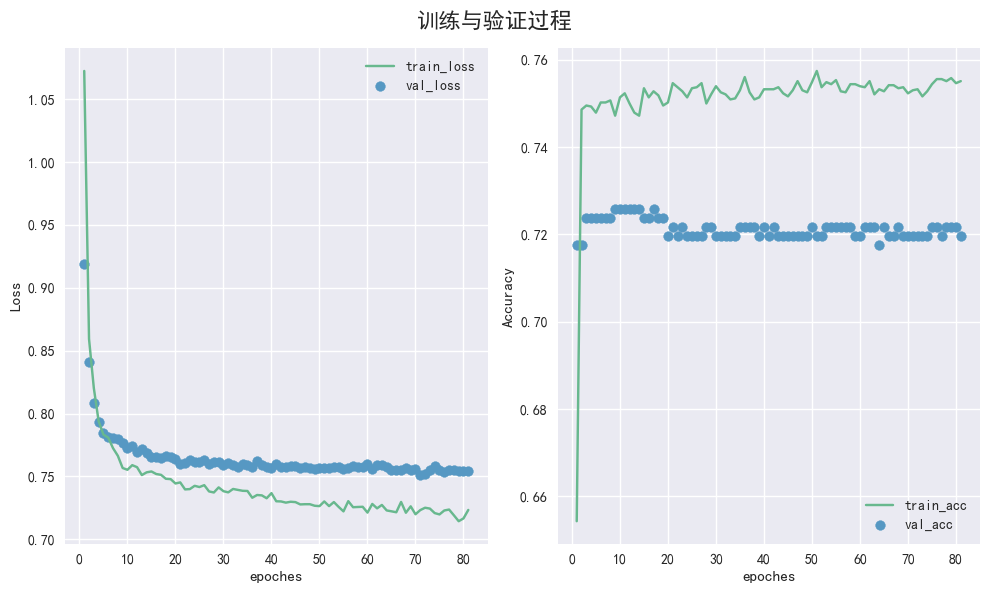

In [10]:
# 构建多层感知机
def create_model(num):
    inputs = Input(shape=(num, ))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(4, activation='softmax')(x)

    FNN = keras.Model(inputs=inputs, outputs=outputs)
    FNN.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return FNN

model = create_model(X_train.shape[1])

# 设置回调函数
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=256,
                    validation_split=0.1,
                    callbacks=[early_stop])

# 保存模型
model.save(r"D:\Study\Python\MchineLearning\DeepLearning\Metacritic\game.keras")

# 评估模型
loss, acc = model.evaluate(X_test, y_test)
auc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')
print(f'acc: {acc:.4f}, auc: {auc:.4f}')

# 读取训练过程
history_dict = history.history

# 读取训练指标
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']

# 读取验证指标
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

# 绘制训练过程
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('训练与验证过程', fontsize=16)
epoches = range(1, len(train_loss) + 1)

axes[0].plot(epoches, train_loss, label='train_loss', color='#68b88e')
axes[0].scatter(epoches, val_loss, label='val_loss', color='#5698c3')
axes[0].set_xlabel('epoches')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epoches, train_acc, label='train_acc', color='#68b88e')
axes[1].scatter(epoches, val_acc, label='val_acc', color='#5698c3')
axes[1].set_xlabel('epoches')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# 显示图表
plt.tight_layout()
plt.show()

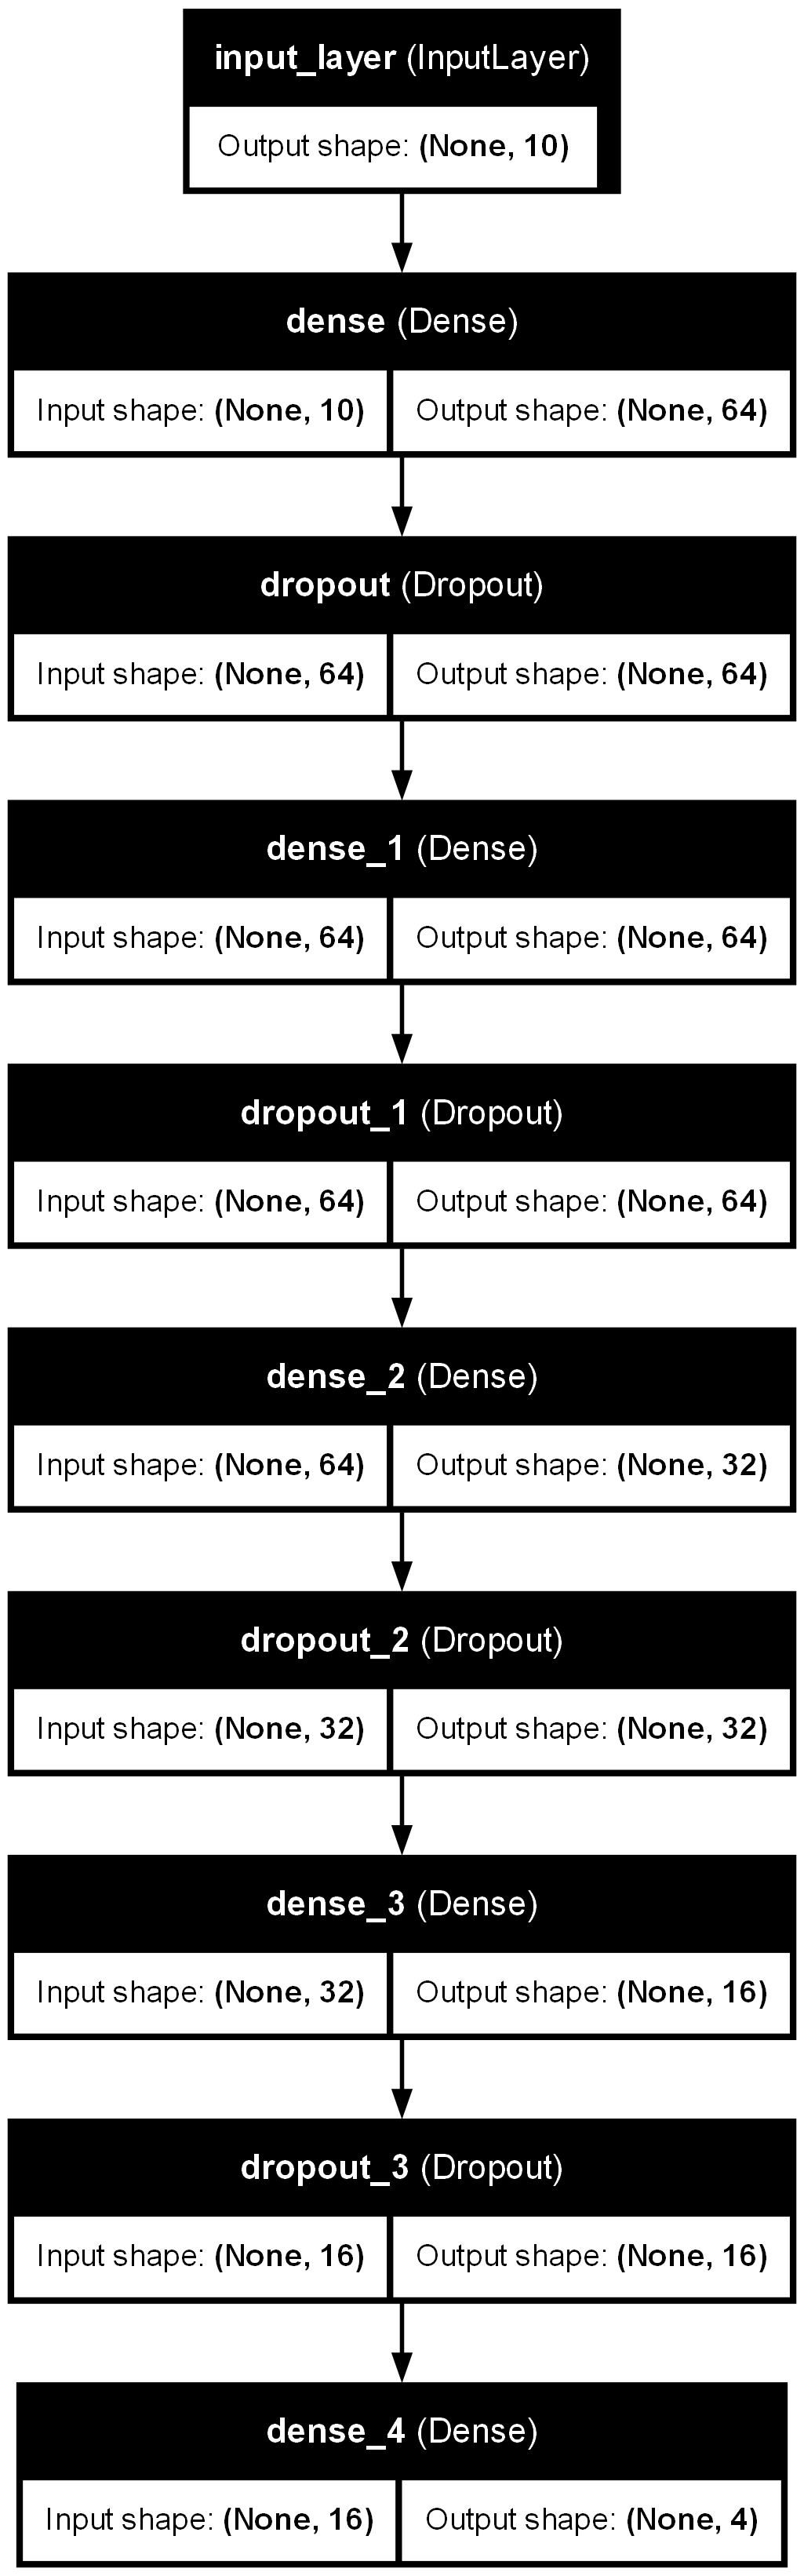

In [7]:
# 绘制模型结构图并保存为文件
png_path = r"D:\Study\Python\MchineLearning\DeepLearning\Metacritic\game.png"
plot_model(model, to_file=png_path, show_shapes=True, show_layer_names=True)

5. 绘制指标图像

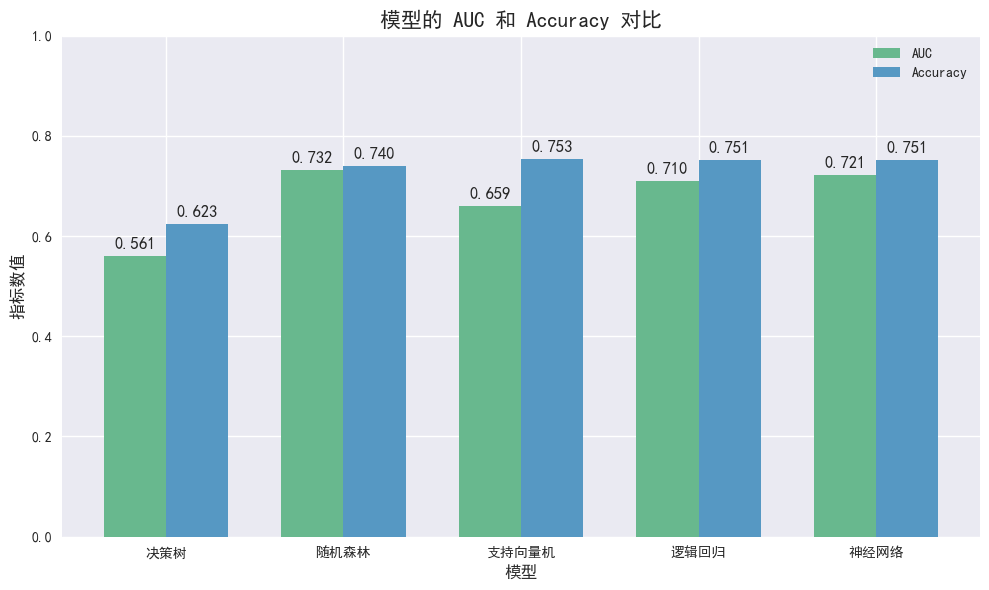

In [11]:
# 添加神经网络数值
auc_dict.update({'神经网络': auc})
acc_dict.update({'神经网络': acc})
models.update({'神经网络': model})

# 读取对应的 AUC 和 Accuracy 分数
auc_scores = auc_dict.values()
acc_scores = acc_dict.values()

# 设置柱状图宽度
bar_width = 0.35
index = np.arange(len(models.keys()))

# 绘制柱状图
plt.figure(figsize=(10, 6))

# 绘制 AUC 和 Accuracy，调整位置以避免重叠
plt.bar(index, auc_scores, bar_width, label='AUC', color='#68b88e')
plt.bar(index + bar_width, acc_scores, bar_width, label='Accuracy', color='#5698c3')

# 添加标题和标签
plt.title('模型的 AUC 和 Accuracy 对比', fontsize=15)
plt.xlabel('模型', fontsize=12)
plt.ylabel('指标数值', fontsize=12)

# 添加 AUC 和 Accuracy 标签
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=12)

for i, v in enumerate(acc_scores):
    plt.text(i + bar_width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=12)

# 设置 x 轴的标签和位置
plt.xticks(index + bar_width / 2, models.keys())

# 设置 y 轴的范围
plt.ylim(0, 1)

# 显示图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

下面是对各个模型表现的总结：

### 1. **决策树**
   - **AUC**: 0.569 (较差)
     - 决策树的 AUC 较低，说明它在区分正负类样本的能力上较弱。可能是因为决策树容易过拟合，特别是在特征比较复杂或样本量较小的情况下。
   - **Accuracy**: 0.631 (中等)
     - 虽然 AUC 较差，但决策树的准确率表现尚可，排名第六。决策树能够对一些简单或非线性的数据做出合理的预测。

   **总结**：决策树的区分能力较弱，但仍能做出一些正确的预测，适用于简单的数据集。对于复杂的任务，可能需要结合集成方法（例如随机森林或梯度提升树）来提高性能。

---

### 2. **朴素贝叶斯**
   - **AUC**: 0.660 (中等)
     - 朴素贝叶斯的 AUC 还算可以，但较低，表明它的分类区分能力不是特别强。可能是由于数据的特征之间存在较强的相关性，而朴素贝叶斯假设特征独立，导致模型不适应此类数据。
   - **Accuracy**: 0.092 (极差)
     - 准确率非常低，说明朴素贝叶斯在实际分类任务中的表现非常糟糕，可能在处理类别不平衡或特征依赖性较强的问题时效果不好。

   **总结**：朴素贝叶斯表现不佳，特别是准确率非常低。它适用于特征之间独立的情况，但对于当前数据集，显然存在不适应的情况。可以排除在此任务之外。

---

### 3. **随机森林**
   - **AUC**: 0.732 (优秀)
     - 随机森林在 AUC 上表现非常好，说明它能够很好地区分正负类样本。随机森林是一个集成模型，通过结合多棵决策树来提高模型的泛化能力。
   - **Accuracy**: 0.740 (优秀)
     - 随着 AUC 的优秀表现，准确率也相对较高，排名第三，说明随机森林能够做出高质量的预测。

   **总结**：随机森林是一个表现非常强大的模型，适合处理复杂的非线性关系和高维数据。无论是 AUC 还是准确率，它的表现都很优秀，是一个非常稳健的选择。

---

### 4. **支持向量机 (SVM)**
   - **AUC**: 0.659 (中等)
     - 支持向量机的 AUC 中等，表现略逊色于随机森林。SVM 的性能常常受到核函数的选择和参数调优的影响，可能需要进一步优化。
   - **Accuracy**: 0.753 (优秀)
     - 准确率表现非常好，排名第二，仅次于神经网络。支持向量机能够在分类任务中做出非常准确的预测，特别是在数据维度较高或类别较复杂时。

   **总结**：支持向量机的准确率很高，但 AUC 较低。对于复杂的分类任务，它通常表现良好，尤其在数据集较为平衡时。通过调整 SVM 的核函数和超参数，可能能够进一步提升其 AUC。

---

### 5. **逻辑回归**
   - **AUC**: 0.710 (良好)
     - 逻辑回归的 AUC 中等，表现优于决策树，但低于随机森林和神经网络。逻辑回归是一个线性模型，可能在数据特征之间存在复杂非线性关系时表现不佳。
   - **Accuracy**: 0.751 (优秀)
     - 准确率很高，排名第三，仅次于支持向量机和神经网络。逻辑回归在处理线性关系较强的数据集时表现非常好。

   **总结**：逻辑回归是一个快速且有效的基线模型，适合线性可分的数据集。它的 AUC 不如一些复杂模型，但在准确率上也有不错的表现，特别是对于简单任务或特征线性关系较强的问题。

---

### 6. **神经网络**
   - **AUC**: 0.712 (良好)
     - 神经网络的 AUC 表现中等，和逻辑回归相当。虽然它能够处理复杂的非线性关系，但在区分能力上并没有突出到领先的程度。
   - **Accuracy**: 0.752 (优秀)
     - 神经网络的准确率最佳，略高于支持向量机，表现出了很强的预测能力。神经网络能够自动从数据中学习特征，适合复杂的非线性问题。

   **总结**：神经网络在准确率上表现最佳，适合处理复杂的数据集，尤其是在特征之间存在复杂的非线性关系时。然而，它的 AUC 并不突出，可能是因为模型需要进一步调整或数据集本身存在挑战。

---

### 总结：
- **最佳模型**：`随机森林` 和 `神经网络`，两者在 AUC 和准确率上都表现优秀。尤其是随机森林，在 AUC 上排名第一，而神经网络在准确率上最好。
- **表现较弱的模型**：`朴素贝叶斯`，在准确率上极差，应该排除。`决策树` 在 AUC 上表现最差。
- **其他有潜力的模型**：`支持向量机` 和 `逻辑回归`，都在准确率上有不错表现，适合基于线性或部分非线性特征的任务。

根据你的任务目标和数据特点，你可以在这些模型中选择最适合的一个或多个进行进一步优化。

# 6. 可视化数据

6.1 绘制关于 Genres 的词云图

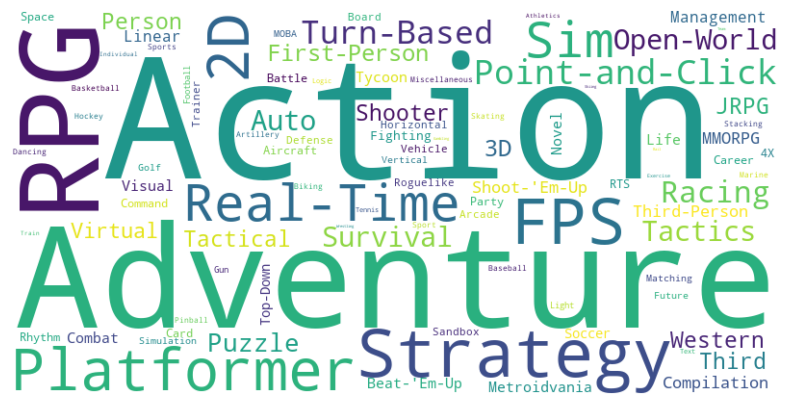

In [9]:
# 统计类型词频
genres = [item for lst in df['Genres'].apply(lambda x: x.split()) for item in lst]
genres_counter = collections.Counter(genres)

# 创建词云图
wordcount = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genres_counter)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcount, interpolation='bilinear')
plt.axis('off')
plt.show()

6.4 关于游戏年份分布的图像

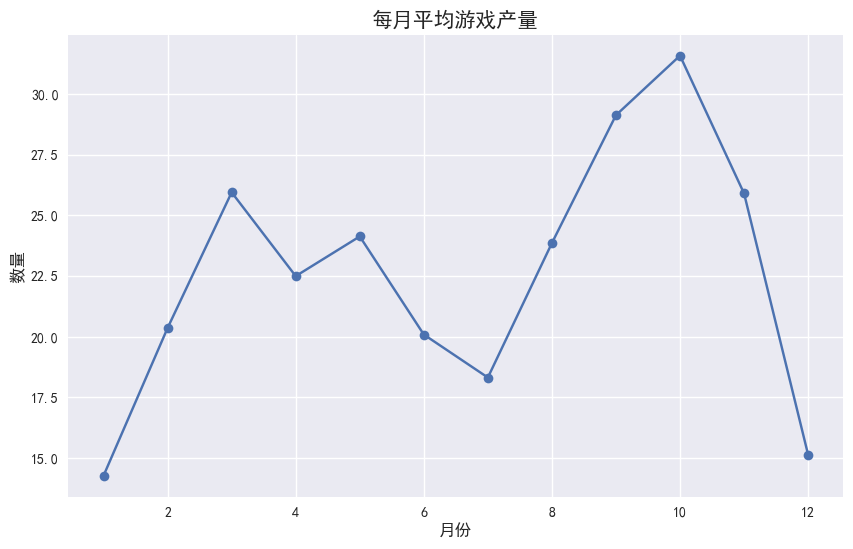

In [10]:
# 聚合每月的游戏产量
game_count = df.groupby('ReleaseMonth').agg(
    game_count=('Name', 'count')
)
# 统计数据中包含年数
num_unique_year = df['ReleaseYear'].nunique()

# 折线图
plt.figure(figsize=(10, 6))
plt.plot(game_count.index, game_count.values / num_unique_year, '-o')
plt.xlabel('月份', fontsize=12)
plt.ylabel('数量', fontsize=12)
plt.title('每月平均游戏产量', fontsize=15)
plt.show()


### 总结：
#### 10月发布游戏的主要原因包括：
#### - **接近假日购物季**：借助圣诞假期的购物高峰，吸引更多玩家购买游戏。
#### - **季节和市场需求**：秋季和冬季是人们倾向于进行室内活动的季节，游戏市场的需求上升。
#### - **适应开发周期**：大型游戏的开发周期可能恰好在10月完成。
#### - **行业惯例**：许多游戏公司和开发商已经习惯在这一时段发布游戏。